In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp


In [2]:
mempool = cp.get_default_memory_pool()
mempool.set_limit(size=4*1024**3)

## Model definition

In [3]:
olfactory_data = pd.read_csv('./Data/statistics_nose_3e6_35_153.dat', sep=',', header=None).values
olfactory_data = np.array(olfactory_data)

In [4]:
# olfactory_data = pd.read_csv('./Data/statistics_nose_5e6.dat', sep=' ', skiprows=[0], header=None).values.T
# olfactory_data = np.array(olfactory_data[:320,:])

In [5]:
# Model size
# env_shape = (280, 1225)
# env_shape = (70,153)
env_shape = olfactory_data.shape
state_count = env_shape[0] * env_shape[1]

print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: (35, 153)
State count: 5355


In [6]:
# goal state
olfactory_data[17,0]

0.9988461538461538

In [7]:
def id_from_pos(x,y):
    return (x * env_shape[1]) + y

In [8]:
# states
state_grid = []

# Rewards
# rewards = np.zeros((state_count, 4, state_count,2))
# rewards[:,:,id_from_pos(17,0),:] = 1

# observation matrix
flattened_olfactory_data = olfactory_data.flatten()

observations = np.zeros((state_count, 4, 2))
observations[:,:,0] = flattened_olfactory_data.reshape((flattened_olfactory_data.shape[0],1)).repeat(4, axis=1)
observations[:,:,1] = (1 - observations[:,:,0])

# Transitions and state labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [9]:
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 4, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West

reachable_states = np.array(reachable_states)

In [10]:
# Reward function
def reward_func(s,a,sn,o):
    # return np.where(sn == (175*env_shape[1]), 1.0, 0.0)
    return np.where(sn == (17*env_shape[1]), 1.0, 0.0)

In [11]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W'],
    observations=['something', 'nothing'],
    reachable_states=reachable_states,
    rewards=reward_func,
    observation_table=observations,
    end_states=[id_from_pos(17,0)]
)

[10/02/2023, 02:17:03] Instantiation of MDP Model:
[10/02/2023, 02:17:03] - 5355 states
[10/02/2023, 02:17:03] - 4 actions
[10/02/2023, 02:17:03] - At most 1 reachable states per state-action pair
[10/02/2023, 02:17:03] - Starting generation of transitions table
[Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[10/02/2023, 02:17:03]     > Done in 0.000s
[10/02/2023, 02:17:03] - Generation of state grid
[10/02/2023, 02:17:03] - Generating start probabilities table
[10/02/2023, 02:17:03] - Starting computation of reachable state probabilities from transition data
[10/02/2023, 02:17:03]     > Done in 0.000s
[10/02/2023, 02:17:03] POMDP particular parameters:
[10/02/2023, 02:17:03] - 2 observations
[10/02/2023, 02:17:03] - Starting of transitional observations for reachable states table
[10/02/2023, 02:17:03]     > Done in 0.000s
[10/02/2023, 02:17:03] - Starting gener

## VI Solve

In [12]:
from src.mdp import VI_Solver

In [13]:
solver = VI_Solver(eps=1e-3)

In [14]:
solution, history = solver.solve(model, use_gpu=True)

[10/02/2023, 02:17:03] Sending Model to GPU...
[10/02/2023, 02:17:03]     > Done in 0.730s


  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
print(history.summary)

Summary of Value Iteration run
  - Model: 5355-state, 4-action
  - Converged in 231 iterations and 1.1912 seconds
  - Took on average 0.0052s per iteration


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


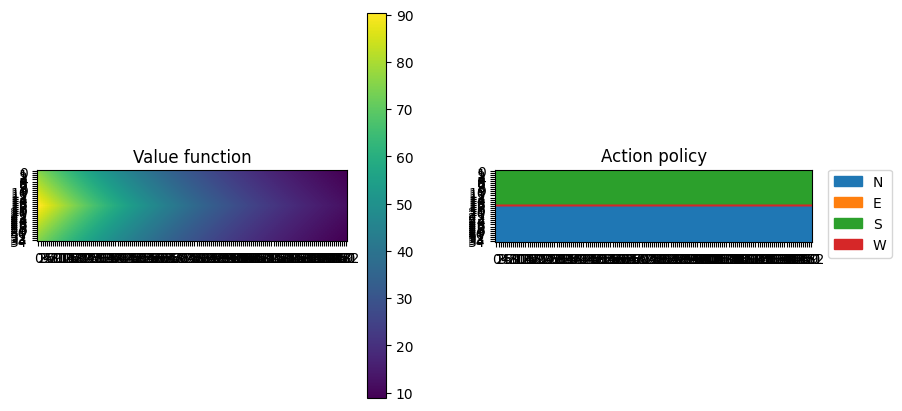

In [16]:
solution.plot()

## FSVI

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model,100,300,solution,use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
print(hist.summary)

Summary of Value Iteration run
  - Model: 5355 state, 4 action, 2 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Converged in 97.6274s

  - Expand function took on average 0.5387s and yielded on average 80.39 beliefs per iteration.
  - Backup function took on average 0.4375s and yielded on average value functions of size 964.96 per iteration.


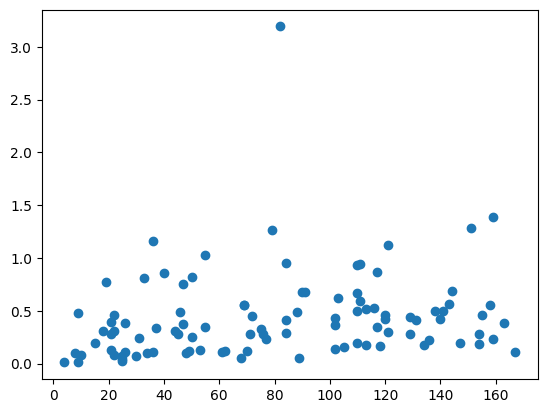

In [21]:
plt.scatter(hist.beliefs_counts[1:], hist.backup_times)

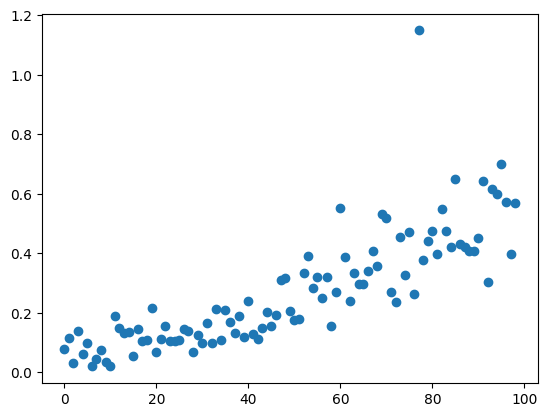

In [26]:
plt.scatter(np.arange(len(hist.backup_times[1:])), hist.backup_times[1:])

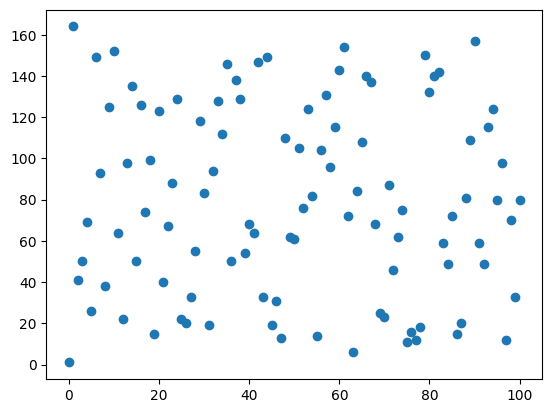

In [25]:
plt.scatter(np.arange(len(hist.beliefs_counts)), hist.beliefs_counts, )

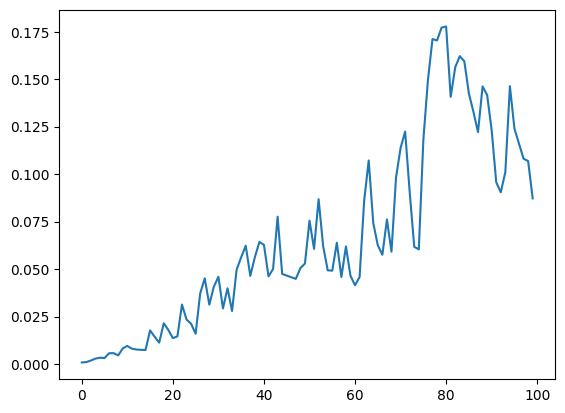

In [28]:
plt.plot(np.arange(len(hist.value_function_changes)), hist.value_function_changes)

## FSVI with mdp solution as initial value function

In [17]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [18]:
fsvi_solution, hist = fsvi_solver.solve(model, 100, 300, mdp_policy=solution, initial_value_function=solution, use_gpu=True)

Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

Converged early...
